<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

### Introduction
A deep neural network (a.k.a. deep learning) is an artificial neural network with multiple layers between the input and output layers. It was proven to be highly effective for a variety of predictive tasks. In health care, deep learning is quickly gaining popularity and has been implemented for applications such as image-based diagnosis and personalized drug recommendations. In this tutorial, we will build a tailored deep-learning model for CyTOF data to diagnosis latent Cytomegalovirus infection using Keras and TensorFlow. 

### Step 1: Import Functions
Before we start, we first import functions that we will use in this tutorial from different libraries. 

In [30]:
##### Step 1: import functions #####
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import set_random_seed; set_random_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus

### Step 2: Load data
We then load the data, which are stored in the "allData.obj" file. For the convenience of this tutorial, the data are downloaded from the ImmPort database and are already preprocessed. The data includes three parts, meta-data, CyTOF data, and marker names. 

* The **meta-data** contains the sample level information, including the study accession number for each sample and the ground truth of CMV infection. It is stored as a pandas data frame. 
* The **CyTOF data** contains the single-cell profile of 27 markers. They are arcsinh transformed data from raw FCS files. It is stored in a three-dimensional numpy array. The dimension of the numpy array is 472 samples x 10000 cells x 27 markers. 
* The **marker names** contain the name of the markers.

In [32]:
##### Step 2: load data #####

#Download data
tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://storage.googleapis.com/focis-tutoria-data/allData.obj -P ./Data
        
#load data
allData = pickle.load( open( "Data/allData.obj", "rb" ) )
metaData = allData["metaData"]
cytoData = allData["cytoData"]
markerNames = allData["markerNames"]

# inspect the data
print("\nFirst 5 rows of metaData: ")
print(metaData.head(),"\n")

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the 27 makers: \n",markerNames.values)


First 5 rows of metaData: 
                                                 name study_accession  CMV_Ab
0   011514-Mike-Study 21-2011-plate 1-2100101_cell...          SDY113    True
1   011514-Mike-Study 21-2011-plate 1-2100201_cell...          SDY113    True
3   011514-Mike-Study 21-2011-plate 1-2100501_cell...          SDY113    True
6   011514-Mike-Study 21-2011-plate 1-2100901_cell...          SDY113   False
19  011514-Mike-Study 21-2011-plate 1-2102501_cell...          SDY113   False 

Dimensions of cytoData:  (472, 10000, 27, 1) 

Names of the 27 makers: 
 ['VIABILITY' 'TCRGD' 'IGD' 'HLADR' 'DNA2' 'DNA1' 'CELL_LENGTH' 'CD94'
 'CD85J' 'CD8' 'CD56' 'CD45RA' 'CD4' 'CD38' 'CD33' 'CD3' 'CD28' 'CD27'
 'CD25' 'CD24' 'CD20' 'CD19' 'CD161' 'CD16' 'CD14' 'CD127' 'CCR7']


### Step 3: Split data into training, validation and testing sets
Now, lets split the data into training, validation, and testing sets. The training data is used to train the deep learning model. The validation dataset is used to select the best parameters for the model and to avoid overfitting. The test dataset is used to evaluate the performance of the final model.

The CyTOF dataset contains samples from 9 studies available on ImmPort. We will use samples from the study SDY515 as a validation set, samples from the study SDY519 as a testing set, and the rest of the samples as a training set. 

In [3]:
##### Step 3: split train, validation and test######
y = metaData.CMV_Ab.values
x = cytoData

train_id = (metaData.study_accession.isin(["SDY515","SDY519"])==False)
valid_id = metaData.study_accession=="SDY515"
test_id = metaData.study_accession =="SDY519"

x_train = x[train_id]; y_train = y[train_id]
x_valid = x[valid_id]; y_valid = y[valid_id]
x_test = x[test_id]; y_test = y[test_id]

### Step 4: Define the deep learning model
We will use a customized convolution neural network (CNN) to analyze the CyTOF data. For each sample, the CyTOF data is a matrix with rows as cells and columns as markers. It is crucial to notice that the order of cells is arbitrary in CyTOF data. For example, both matrix 1 and matrix 2 profiles the same sample in Figure 1A, even though they have different orders of rows. 

![alt text](Data/Figure1.png)


Based on the characteristics of the CyTOF data, we design a CNN model to predict sample-level information using the raw CyTOF data as input. The model contains six layers: input layer, first and second convolution layer, pooling layer, dense layer, and output layer. 

* The **input layer** receives the CyTOF data matrix. 

* The **first convolution layer** uses three filters to scan each row of the CyTOF data. This layer extracts relevant information from the cell marker profile of each cell. 

* The **second convolution layer** uses three filters to scan each row of the first layer's output. Each filter combines information from the first layer for each cell. 

* The **pooling layers** averages the outputs of the second convolution layer. The purpose is to aggregate the cell level information into sample-level information. 

* The **dense layer** further extracts information from the pooling layer. 

* The **output layer** uses logistic regression to report the probability of CMV infection for each sample. 


In [4]:
##### Step 4: define model #####

# input
model_input = Input(shape=x_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

Instructions for updating:
Colocations handled automatically by placer.


### Step 5: Fit the model
In this step, we will use the training data to fit the model. We will use the Adam algorithm, which is an extension of the gradient descent method to train our model. Adam algorithm will search the model space step by step (epochs) until the optimal model is identified. At each step, we will use validation data to evaluate the performance of the model. The best model will be saved. 

To save time, we will only run the first 150 epochs as a demonstration. We will load the final model from a save file (Final_weights.hdf5) for the following analysis steps. 

In [10]:
##### Step 5: Fit model #####

# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

# save the best performing model using validation result
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=500, # increase the epochs to 500 to fully train the model
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 333 samples, validate on 79 samples
Epoch 1/500
333/333 [==============================] - 12s 35ms/step - loss: 0.8607 - acc: 0.4595 - val_loss: 0.7309 - val_acc: 0.5443
Epoch 2/500
333/333 [==============================] - 8s 24ms/step - loss: 0.8600 - acc: 0.4505 - val_loss: 0.7331 - val_acc: 0.5316

### Step 6: Plot the training history
We can view the training history of the model by plotting the performance (value of the loss function) for training and validation data in each epoch. 

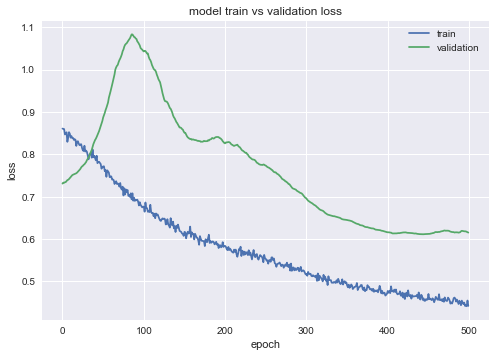

In [11]:
##### Step 6: plot train and validation loss #####
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Step 7: Evaluate the performance using test data
We now use the test data, which has not been touched so far, to evaluate the performance of the final model. We will draw a Receiver Operator Characteristic(ROC) Curve and use Area Under the Curve (AUC) to measure performance. 

Instructions for updating:
Use tf.cast instead.


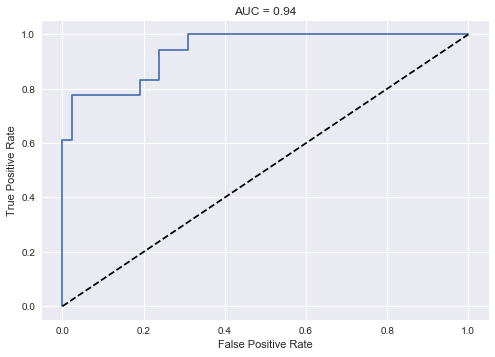

/Users/zichenghu/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


In [5]:
##### Step 7: test the final model #####

# load final model
final_model = load_model('Data/Final_weights.hdf5')

# generate ROC and AUC
y_scores = final_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

# Plot predicted Probability of CMV infection
pred = pd.DataFrame({"Probability":y_scores[:,0], "CMV":(y_test==1.0)})
sns.stripplot(y = "Probability", x = "CMV",data=pred);
sns.boxplot(y = "Probability", x = "CMV",data=pred);

### Step 8: Identify cells activated in the convolutional layers using a decision tree
The internal nodes in the convolutional layers have one-to-one correspondence with cells in CyTOF data. Because of this, we can discover cells associated with the CMV infection by identifying nodes with high activation values. As an example, we will first build a decision tree model to identify highly activated nodes in filter 1 of convolutional layer 2. We then test the association between the identified cell subset and CMV infection. We choose to use a decision tree model because it is highly interpretable and is structurally similar to hieratical gating. 

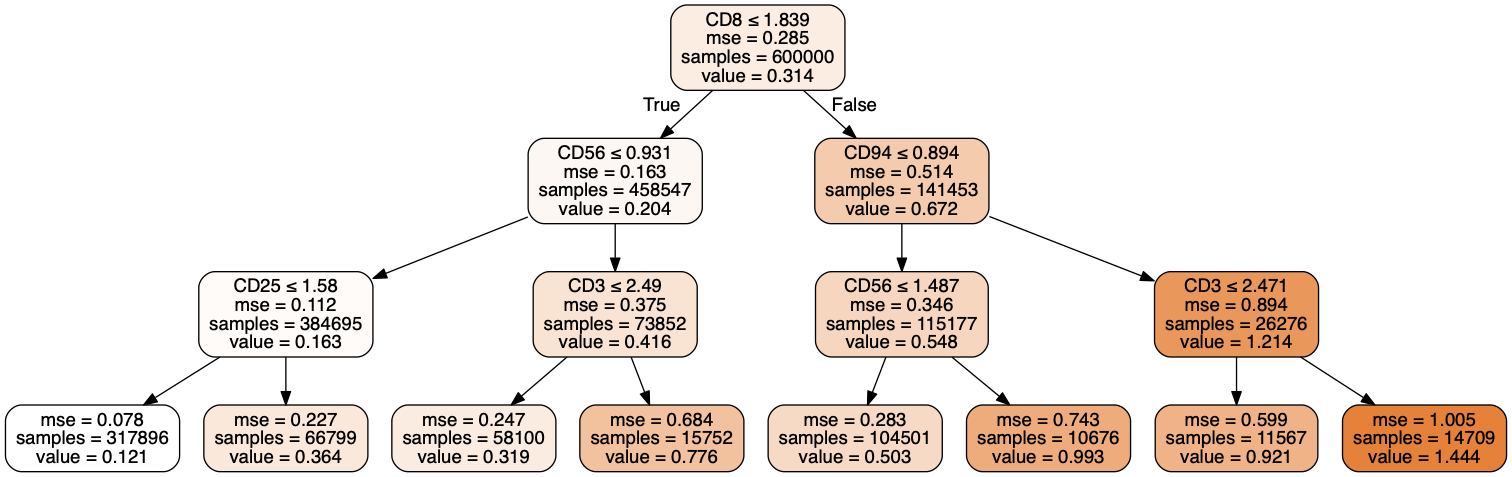

In [33]:
##### Step 8: Identify cells associated with CMV using a decistion tree #####

# extract activation value in filter 1 convolutional layer 2
get_activation = K.function([final_model.layers[0].input],
                                  [final_model.layers[6].output])
activation_value = get_activation([x_test])[0]
activation_value = activation_value[:,:,:,0]
activation_value = activation_value.reshape(activation_value.shape[0]*activation_value.shape[1])

# build the decision tree
x_test2 = x_test.reshape((x_test.shape[0]*x_test.shape[1],27))
 
regr_1 = DecisionTreeRegressor(max_depth=3)
regr_1.fit(x_test2, activation_value)

# plot the decision tree
dot_data = StringIO()
export_graphviz(regr_1, out_file=dot_data, 
                feature_names= markerNames,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Step 9: Test the association between CMV and CD8+ CD94+ CD3+ cells
The decision tree identified a CD8+ CD94+ CD3+ cell population to be highly activated. To see if this cell population is associated with CMV infection, we first quantify the proportion of CD8+ CD94+ CD3+ cell in each subject, and compare the proportions in CMV+ and CMV- populations. 

/Users/zichenghu/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


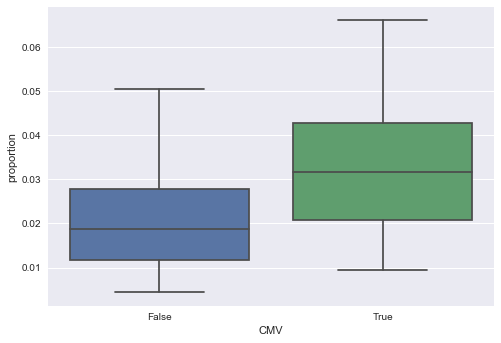

P value =  0.00275819644694


In [29]:
##### plot association between CMV and CD8+ CD94+ CD3+ cell and CMV infection #####

# Identify the leaf that have the highest activation value
pred = regr_1.predict(X=x_test2)
leaf = regr_1.apply(x_test2)
max_leaf = [leaf[np.argmax(pred)]]

# quantify the proportion of CD8+ CD94+ CD3+ population
leaf = np.isin(leaf,max_leaf)
leaf = leaf.reshape(x_test.shape[0],x_test.shape[1])
leaf = np.mean(leaf, 1)
proportion_CMV = pd.DataFrame({"proportion":leaf,"CMV":y_test})

# plot the proportion of CD8+ CD94+ CD3+ cells
sns.boxplot(x="CMV", y="proportion", data=leaf_CMV)
plt.show()

# test the difference between CMV+ and CMV- population
test1 = ttest_ind(proportion_CMV.proportion[leaf_CMV.CMV==1],
          proportion_CMV.proportion[leaf_CMV.CMV==0], 
          equal_var = False)
print("P value = ", test1[1])

### Conclusion
In this tutorial, we build a deep convolutional neural network (CNN) to analyze CyTOF data. The deep CNN model is able to diagnose latent CMV infection with high accuracy. In addition, we were able to interpret the convolutional layers using decision trees. We discovered that a CD3+ CD8+ CD94+ population is highly activated in filter 1 of the second convolutional layer. The population is significantly associated with CMV infection. 